In [27]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
from textstat.textstat import textstat
from gensim.corpora import wikicorpus
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import nltk
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
# Make it pretty
plt.style.use('ggplot')

In [28]:
file = '../data/enwiki.observations.text_wp10.30k.tsv'
raw_data = pd.read_csv(file, sep='\t', header=None)

In [29]:
data = pd.DataFrame(data=list(raw_data[0].apply(literal_eval)))
data = data[data['text'] != ""]
data = data[data['text'].str.contains("#redirect") == False]
data = data[data['text'].str.contains("may refer to:\n\n*") == False]
data = data[data['text'].str.contains("can refer to:\n") == False]
data = data[data['text'].str.contains("could refer to:\n") == False]
data = data[data['text'].str.contains("#REDIRECT") == False]
data = data[data['text'].str.contains("== Matches ==\n:") == False]
data = data[data['text'].str.contains("{{underconstruction") == False]

In [31]:
data1000 = data[:10000].copy()

In [32]:
classes = {"stub": 0, "start": 1, "c": 2, "b": 3, "ga": 4, "fa": 5} 
data1000["label"] = data1000['label'].map(classes)
data1000

,label,page_title,project,text,timestamp
0,5,Funerary art,visual arts,[[Image:GD-FR-Paris-Louvre-Sculptures034.JPG|3...,20100504203659
1,5,Battle of Warsaw (1920),russia,{{Infobox Military Conflict\n|conflict=Battle ...,20070111175847
2,2,Henry Digby (Royal Navy officer),biography,{{Use British English|date=August 2011}}\n{{Us...,20111205102850
3,2,Ottawa Redblacks,canadian football,{{Use mdy dates|date=May 2013}}\n{{Infobox CFL...,20140513220942
4,2,Qimonda,germany,{{Infobox_Company |\n company_name = Qimond...,20090315202104
5,1,"Ocracoke, North Carolina",project north carolina,{{Infobox Settlement\n|official_name ...,20080911150022
6,2,Erik Wilhelm,biography,{{construction}}\n\n{{Infobox NFL player\n| im...,20141125183748
7,0,Kolibite,bulgaria,{{Infobox settlement \n|official_name =Kolibit...,20120524063028
8,3,Edouard Borovansky,ballet,{{Infobox Person\n| name = Edouard Borovansk...,20110208153146
9,0,Jacek Wiśniewski,poland,{{Football player infobox\n| playername= Jacek...,20090105062145


In [8]:
def clean_wiki_markup(raw_article):
    semi_cleaned_article = wikicorpus.filter_wiki(raw_article)
    cleaned_article = semi_cleaned_article.replace("\n", "").replace("\'", "").replace("()", "").replace("=", "").replace("|alt","").replace("\xa0","")
    return cleaned_article

def find_num_categories(raw_article):
    return raw_article.count("[[Category:")

def find_num_images(raw_article):
    return raw_article.count("[[Image:")

def find_num_ISBN(raw_article):
    return raw_article.count("ISBN")

def find_num_references(raw_article):
    return raw_article.count("</ref>")

def find_article_length(cleaned_article):
    return len(cleaned_article)

def find_num_difficult_words(cleaned_article):
    return textstat.difficult_words(cleaned_article)

def find_dale_chall_readability_score(cleaned_article):
    return textstat.dale_chall_readability_score(cleaned_article)

def find_automated_readability_index(cleaned_article):
    return textstat.automated_readability_index(cleaned_article)

def find_linsear_write_formula(cleaned_article):
    return textstat.linsear_write_formula(cleaned_article)

def find_gunning_fog_index(cleaned_article):
    return textstat.gunning_fog(cleaned_article)

def find_syllable_count(cleaned_article):
    return textstat.syllable_count(cleaned_article)

def find_lexicon_count(cleaned_article):
    return textstat.lexicon_count(cleaned_article, removepunct=True)

def find_sentence_count(cleaned_article):
    return textstat.sentence_count(cleaned_article)

def find_smog_index(cleaned_article):
    return textstat.smog_index(cleaned_article)

def find_num_web_citations(raw_article):
    return raw_article.count("{{cite web")

def find_num_book_citations(raw_article):
    return raw_article.count("{{cite book")

def find_num_news_citations(raw_article):
    return raw_article.count("{{cite news")

def find_num_quotes(raw_article):
    return raw_article.count("quote=")

def find_num_h3_headers(raw_article):
    return raw_article.count("\n===")

def find_num_internal_links(raw_article):
    return (raw_article.count("[[") // 2)

def find_num_h2_headers(raw_article):
    return (raw_article.count("\n==") - find_num_h3_headers(raw_article))

In [33]:
data1000['cleaned_text'] = data1000['text'].apply(clean_wiki_markup)

In [10]:
data1000

,label,page_title,project,text,timestamp,cleaned_text
0,5,Funerary art,visual arts,[[Image:GD-FR-Paris-Louvre-Sculptures034.JPG|3...,20100504203659,Burgundy under Louis XIA large sculpture of s...
1,5,Battle of Warsaw (1920),russia,{{Infobox Military Conflict\n|conflict=Battle ...,20070111175847,The Battle of Warsaw (sometimes referred to as...
2,2,Henry Digby (Royal Navy officer),biography,{{Use British English|date=August 2011}}\n{{Us...,20111205102850,Admiral of the Blue Sir Henry Digby GCB (20 Ja...
3,2,Ottawa Redblacks,canadian football,{{Use mdy dates|date=May 2013}}\n{{Infobox CFL...,20140513220942,TD Place StadiumThe Ottawa RedBlacks (stylized...
4,2,Qimonda,germany,{{Infobox_Company |\n company_name = Qimond...,20090315202104,"Qimonda AG , (pronounced ""key-MON-da"") is a m..."
5,1,"Ocracoke, North Carolina",project north carolina,{{Infobox Settlement\n|official_name ...,20080911150022,Ocracoke IslandOcracoke is a census-designated...
6,2,Erik Wilhelm,biography,{{construction}}\n\n{{Infobox NFL player\n| im...,20141125183748,"Erik Bradley Wilhelm (born November 16, 1965 i..."
7,0,Kolibite,bulgaria,{{Infobox settlement \n|official_name =Kolibit...,20120524063028,Kolibite is a village in the municipality of S...
8,3,Edouard Borovansky,ballet,{{Infobox Person\n| name = Edouard Borovansk...,20110208153146,Edouard Borovansky (24 February 1902 – 18 Dece...
9,0,Jacek Wiśniewski,poland,{{Football player infobox\n| playername= Jacek...,20090105062145,"Jacek Wiśniewski (born June 8, 1974 in Gliwice..."


# HashVectorizer

In [11]:
hash_vectorizer = HashingVectorizer(n_features=5000)

### Fit Vectorizer

In [34]:
hash_vectorizer.fit(data1000['cleaned_text'])

HashingVectorizer(alternate_sign=True, analyzer='word', binary=False,
         decode_error='strict', dtype=<class 'numpy.float64'>,
         encoding='utf-8', input='content', lowercase=True,
         n_features=5000, ngram_range=(1, 1), non_negative=False,
         norm='l2', preprocessor=None, stop_words=None, strip_accents=None,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None)

### Transform Vectorizer

In [35]:
X_transformed = hash_vectorizer.transform(data1000['cleaned_text'])

In [36]:
hash_df = pd.DataFrame(X_transformed.todense())

In [37]:
y = data1000.label.values

# Train/Test Split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(hash_df.values, y, test_size=0.20, random_state=910)

# Random Forest Regressor

In [39]:
rf = RandomForestRegressor(n_estimators=10, random_state=910)

In [40]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=910, verbose=0, warm_start=False)

In [41]:
predictions = rf.predict(X_test)

In [42]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, predictions)

1.0636905555555554

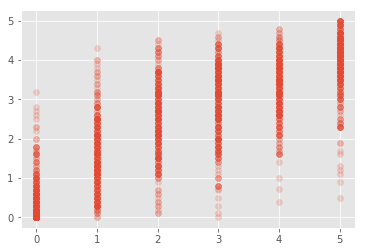

In [45]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, alpha=.2)